# 0) Import des Librairies

---



In [ ]:
#pip install prophet

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import seaborn as sns
import plotly.figure_factory as ff

import numpy as np

In [2]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

C:\Users\edmee\AppData\Local\Temp\ipykernel_12580\1233923705.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',30)

In [4]:
import zipfile

In [5]:

chemin_zip = './Data/donnee_ts.zip'
dossier_extraction = './Data'

with zipfile.ZipFile(chemin_zip, 'r') as zip_ref:
    zip_ref.extractall(dossier_extraction)

In [5]:
df=pd.read_csv('./Data/donnee_ts.csv')
del df["Unnamed: 0"]

C:\Users\edmee\AppData\Local\Temp\ipykernel_12580\1678533545.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('./Data/donnee_ts.csv')


# Stations

In [6]:
a=df.groupby(["libelle_departement", "code_cours_eau","code_station"]).agg({"resultat_obs_elab": "count" })

In [7]:
df["code_station"].nunique()

711

On a 711 stations à étudier. 
Nous allons commencer par nous focaliser sur celle avec le plus de data

In [9]:
nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
nb_values = nb_values.sort_values(ascending=False)
nb_values

code_station
E642601001    6862
A325021001    6862
B532201001    6862
H224000501    6862
A243003001    6862
              ... 
B423000102      27
A664031001      27
1221000101      24
B700001002      13
F400000101       6
Name: resultat_obs_elab, Length: 711, dtype: int64

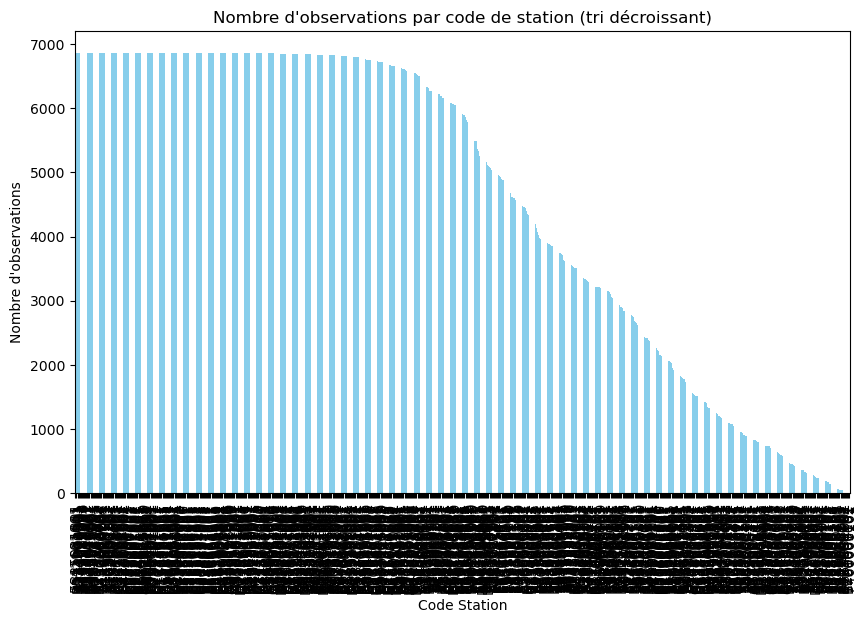

In [10]:


nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
nb_values = nb_values.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
nb_values.plot(kind='bar', color='skyblue')

plt.xlabel('Code Station')
plt.ylabel('Nombre d\'observations')
plt.title('Nombre d\'observations par code de station (tri décroissant)')

plt.show()


In [33]:
# nb_values = df.groupby("code_station")["resultat_obs_elab"].count()
# big_station=nb_values[nb_values>5000]
# df = df[df["code_station"].isin(big_station.index)]

# Fonctions de visualisaiton 

Pour visualiser les données

In [20]:
def visu(ts):
    nom_station = ts["libelle_station"].iloc[0]
    
    ts['date_obs_elab'] = pd.to_datetime(ts['date_obs_elab'])
    
    # Tracé d'un graphique temporel
    plt.figure(figsize=(15, 6))
    plt.plot(ts["date_obs_elab"], ts["resultat_obs_elab"], linewidth=3)
    plt.title(f'Stations {nom_station}')
    plt.show()

    # Histogramme
    fig = px.histogram(ts, x="resultat_obs_elab")
    fig.update_layout(title=f'Stations {nom_station}')
    fig.show()  

    # Box plot mensuel
    ts['Mois'] = ts['date_obs_elab'].dt.month_name()
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Mois', y='resultat_obs_elab', data=ts)
    plt.xlabel('Mois')
    plt.ylabel('Résultat Observation Elab')
    plt.title(f'Stations {nom_station}')
    plt.xticks(rotation=45)
    plt.show()



# Fonction de mise en forme

In [9]:
def mise_en_forme(ts):
    ts=ts[['date_obs_elab','resultat_obs_elab']]
    ts['date_obs_elab'] = pd.to_datetime(ts['date_obs_elab'])

    train_size = int(len(ts) * 0.8)
    train, test = ts[:train_size], ts[train_size:]
   
    train_r=train.rename(columns={'date_obs_elab':'ds',
                        'resultat_obs_elab':'y'})

    test_r=test.rename(columns={'date_obs_elab':'ds',
                        'resultat_obs_elab':'y'})
    return train_r, test_r

# Modele

Création du modèle, et on utilise le modèle sur la base test

In [10]:
def model(train_r,test_r):
    model = Prophet(
    yearly_seasonality=12,  # Increase the number of Fourier terms
    seasonality_prior_scale=0.8,  # Adjust the seasonality prior scale
    )

    model.fit(train_r)  
    test_fcst = model.predict(df=test_r)

    future_dates = model.make_future_dataframe(periods=6*12*30, freq='D')  
    forecast = model.predict(future_dates)
    return (model, test_fcst,forecast)

Visualisation des données forecaster du modèle

In [22]:
def visu_ts( test_r,test_fcst, model ):
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax.scatter(test_r["ds"], test_r['y'], color='r')
    fig = model.plot(test_fcst, ax=ax)

In [23]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def erreur(test_r, test_fcst):
    a=mean_absolute_percentage_error(y_true=test_r['y'],
                    y_pred=test_fcst['yhat'])
    b=mean_absolute_error(y_true=test_r['y'],
                    y_pred=test_fcst['yhat'])
    print(f"Erreur moyenne absolue: {b} \nPOurcentage moyen de l'erreur absolue: {a}")
    

# Seuil

In [13]:
def visu_seuil( test_r,test_fcst, model, quantile ):
    
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    ax.scatter(test_r["ds"], test_r['y'], color='r', label='Données réelles')
    plt.axhline(y=quantile, color='y', linestyle='--', label=f'Quantile 98% ({quantile:.2f})')
    ax.set_title('Visualisation des prévisions avec le seuil ')
    fig = model.plot(test_fcst, ax=ax)
    ax.legend()
    plt.show()

In [12]:

def visu_seuil(test_r, test_fcst, model, quantile):

    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    
    ax.scatter(test_r["ds"], test_r['y'], color='r', label='Données réelles')
    
    # Ajout de la ligne horizontale pour le quantile
    plt.axhline(y=quantile, color='y', linestyle='--', label=f'Quantile 98% ({quantile:.2f})')
    
    # Tracé des prévisions du modèle
    model.plot(test_fcst, ax=ax, label='Prévisions du modèle')
    
    # Ajout du titre
    ax.set_title('Visualisation des prévisions avec le seuil ')
    
    # Affichage de la légende
    ax.legend()
    
    plt.show()


In [21]:
def visu_seuil(test_r, test_fcst, model, quantile):

    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    
    ax.scatter(test_r["ds"], test_r['y'], color='r', label='Données réelles')
    
    # Ajout de la ligne horizontale pour le quantile
    plt.axhline(y=quantile, color='y', linestyle='--')
    
    # Tracé des prévisions du modèle
    model.plot(test_fcst, ax=ax, label='Prévisions du modèle')
    
    # Ajout du titre
    ax.set_title('Visualisation des prévisions avec le seuil ')
    
    # Affichage de la légende
    ax.legend()
    
    plt.show()


# Stations

In [14]:
#Choix de la station
data=df[df["code_station"]=="A325021001"]

In [30]:
def construction_ts(station, quantile):
    visu(station)

    #mise en forme et séparation train/test
    train,test=mise_en_forme(station)

    modele, prediction, pred_futur = model(train,test)

    # visu_ts(test,prediction, modele )
    
    # visu_ts(test,pred_futur, modele )

    erreur(test, prediction)

    
    quantile_80 = data["resultat_obs_elab"].quantile(quantile)
    visu_seuil( test,pred_futur, modele, quantile_80 )

    count_over_quantile = (pred_futur["yhat"] > quantile_80).sum()

    print(f"Nombre de fois où la hauteur est supérieur au quantile {quantile}, qui est de {quantile_80:.0f} mètres : {count_over_quantile} dans les {len(pred_futur['yhat'])} prochain jours")

    return(pred_futur)



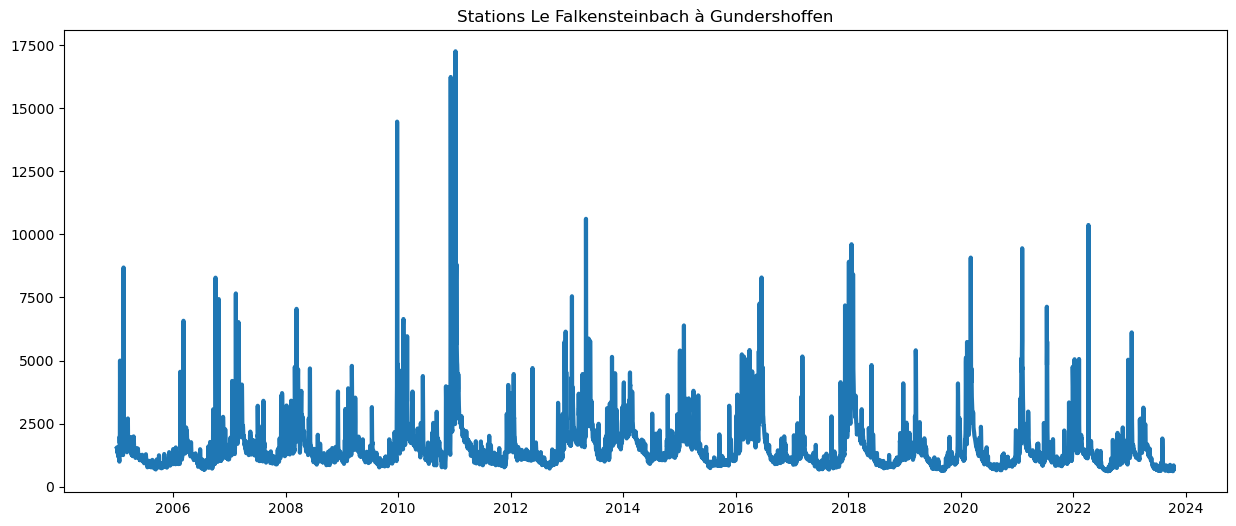

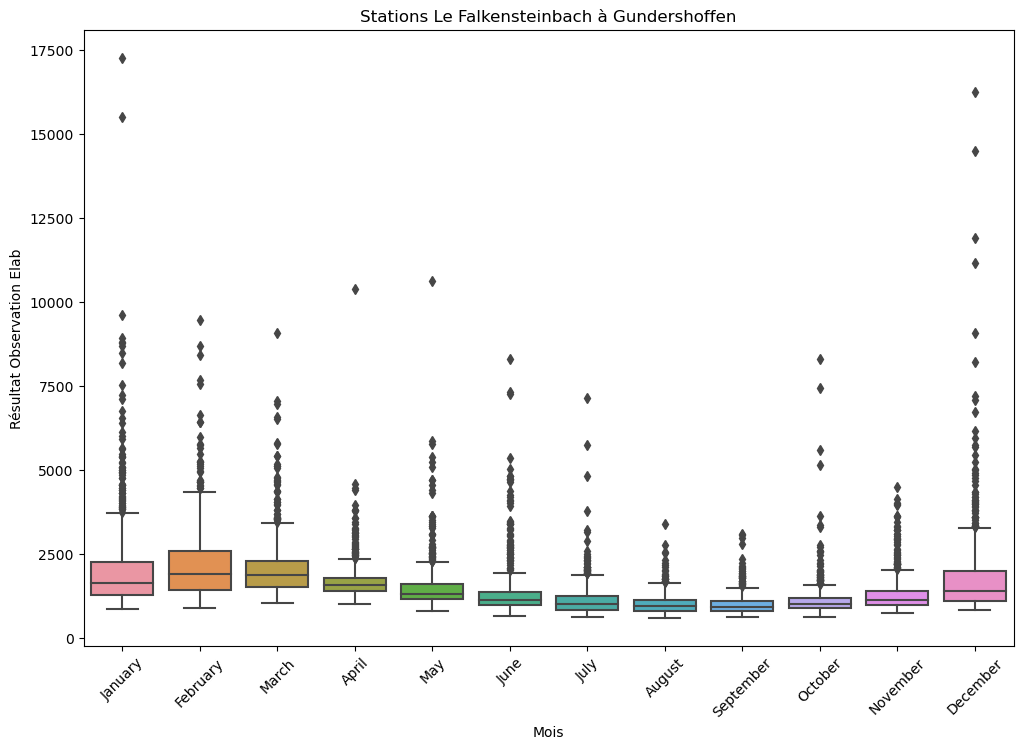

19:45:51 - cmdstanpy - INFO - Chain [1] start processing
19:45:53 - cmdstanpy - INFO - Chain [1] done processing


Erreur moyenne absolue: 445.7531166611762 
POurcentage moyen de l'erreur absolue: 28.9819568779925


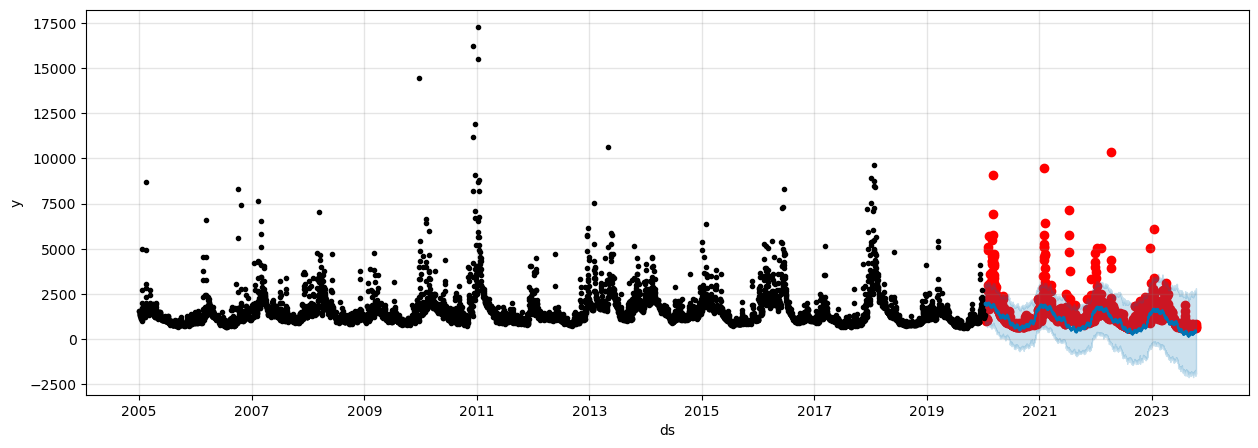

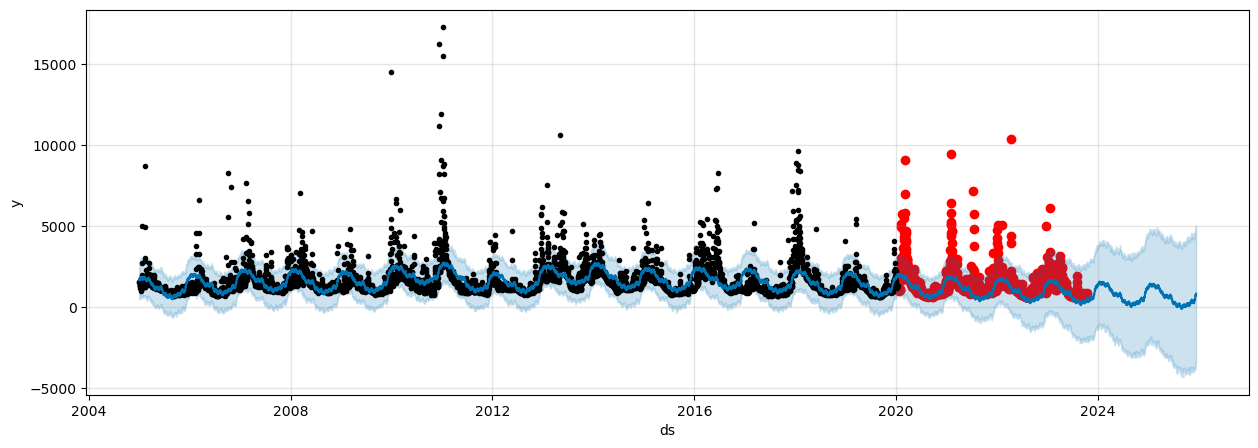

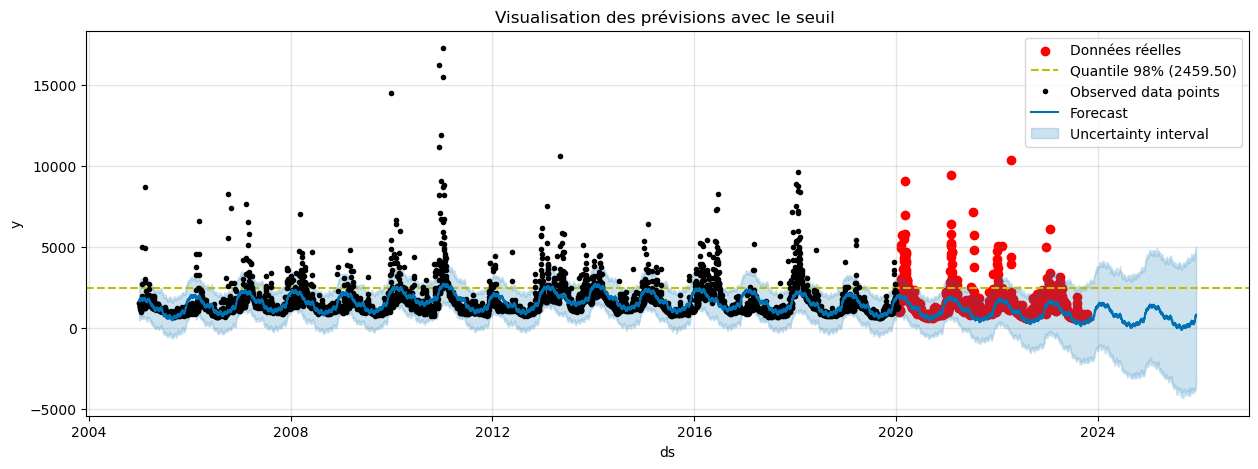

Nombre de fois où la hauteur est supérieur au quantile 0.9, qui est de 2460 mètres : 217 dans les 7649 prochain jours


In [31]:
pred=construction_ts(data,0.9)


Pour récuper uniquement les données prédites par le modèle

In [32]:
predictions=pred[["ds", "yhat"]]
predictions

,ds,yhat
0,2005-01-01,1741.350546
1,2005-01-02,1673.393190
2,2005-01-03,1628.556734
3,2005-01-04,1701.118313
4,2005-01-05,1715.470772
...,...,...
7644,2025-12-06,756.144117
7645,2025-12-07,714.092940
7646,2025-12-08,693.505846
7647,2025-12-09,788.457647


In [28]:
quantile_80 = data["resultat_obs_elab"].quantile(0.8)
count_over_quantile = (predictions["yhat"] > quantile_80).sum()


print(f"Nombre de fois où la hauteur est supérieur au quantile 80% : {count_over_quantile} dans les {len(predictions['yhat'])} prochain jours")

Nombre de fois où la hauteur est supérieur au quantile 80% : 1784 dans les 7649 prochain jours


In [29]:
quantile_80 = data['resultat_obs_elab'].quantile(0.8)
print(quantile_80)

1862.0
